In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words: # for each word
  #print(w)
  context = [0] * block_size # initialize context as ... for whatever block size is
  for ch in w + '.': # for each character in the word plus the end character
    ix = stoi[ch] # the int version of the char
    X.append(context) # the last block_size chars (padded with .) context is the input example
    Y.append(ix) # the current char is the expected output
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # create the new block_size char input - crop the context and append the current char
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

# see above
def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42) # use same seed for reproducability
random.shuffle(words) # randomize the words in case there was an ordering in the file
n1 = int(0.8*len(words)) # use 80% of the words as training
n2 = int(0.9*len(words)) # 10% as dev
                         # 10% implied as test
    
Xtr, Ytr = build_dataset(words[:n1]) # training set used to tune the weights
Xdev, Ydev = build_dataset(words[n1:n2]) # dev set used to tune hyperparams like context length, # of neurons, etc.
Xte, Yte = build_dataset(words[n2:]) # testing set used only for testing final model
                                     # any time test set is used and you act on the result, increases odds of overfitting

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [18]:
C = torch.randn((27, 2)) # create a two-diminsional representation of each letter
emb = C[X] # for each entry of X, index into the new representation and convert the letter's int into the letter's 2D representation
emb

tensor([[[-1.0374,  0.1667],
         [-1.0374,  0.1667],
         [-1.0374,  0.1667]],

        [[-1.0374,  0.1667],
         [-1.0374,  0.1667],
         [ 0.0534, -0.2418]],

        [[-1.0374,  0.1667],
         [ 0.0534, -0.2418],
         [-0.9791,  0.5294]],

        ...,

        [[-0.1400,  1.9322],
         [-0.1400,  1.9322],
         [ 0.1400, -0.1187]],

        [[-0.1400,  1.9322],
         [ 0.1400, -0.1187],
         [-0.1400,  1.9322]],

        [[ 0.1400, -0.1187],
         [-0.1400,  1.9322],
         [ 0.7899, -1.5023]]])

In [19]:
W1 = torch.randn((6, 100)) # the first layer of neurons/nodes has 6 inputs (3 for the 3 letters * 2 for the 2D embedding) and 100 nodes which we chose arbitrarily
print(W1)
b1 = torch.randn(100) # each of the 100 nodes has a bias
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # use tanh as our activation function for this layer, each neuron is the result of a matrix multiplication @ of the embedding vector and node weights plus matrix add of the bias
# emb.view splices the tensor into segments of the size you direct, -1 says "i don't care how many on this dimension"
# <input examples>, 6 @ 6, 100 -> <input examples>, 100

tensor([[-0.0460,  0.3472, -1.0911,  1.7026, -1.3938,  1.1187, -0.6547, -1.0061,
         -0.8308,  0.5834,  0.0801, -0.7296,  1.0592,  0.9821,  0.5626, -0.0370,
         -1.1045,  0.8141,  0.9736,  0.9727, -0.6314, -0.8894,  0.8331,  0.2243,
          0.1303,  0.0192, -0.8156,  0.4403,  0.0500,  1.1348,  0.1381, -0.0298,
          1.5608,  0.9785, -1.2572,  0.9908,  1.0611, -1.3221,  0.0455, -0.1580,
          1.0103,  0.7780, -0.7421, -0.0385, -1.0434, -0.5245,  0.6198, -1.2322,
         -2.2240,  0.6374, -0.6505, -0.8946, -0.1704,  2.1905, -1.5858,  0.6223,
         -1.2453,  0.5773,  0.5614,  0.6184, -0.9413,  0.2722, -1.5246, -0.8541,
          0.0237, -0.4261,  1.2794, -1.8232,  0.4789, -0.7284, -0.3925, -0.2038,
          1.7221, -0.4401,  0.8417, -0.8979, -0.0131,  2.2202,  0.2407,  0.4217,
         -0.6118, -1.3940,  0.4757,  1.1767, -0.5104,  0.1010,  0.4588,  0.3638,
          1.9923,  1.3494,  2.4204,  1.5222, -1.6991,  0.8304,  0.0133,  0.2990,
         -0.1662, -1.0954,  

In [13]:
W2 = torch.randn((100, 27)) # next layer has 100 inputs (for the 100 nodes in first layer) and 27 outputs (1 per char)
b2 = torch.randn(27) # one bias per node
logits = h @ W2 + b2 # non-normalized output of this layer

In [ ]:
counts = logits.exp() # exponentiate logits (e^logit) to get the expected "count" of each character coming next
prob = counts / counts.sum(1, keepdims=True) # normalize the counts to get a <0,1> probability
loss = -prob[torch.arange(32), Y].log().mean() # the loss is the mean of the negative log odds of the actual value being chosen by the model

In [21]:
# ------------ now made respectable :) ---------------

In [22]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g) # 10dimensional rep of 27 symbols
W1 = torch.randn((30, 200), generator=g) # 10*3 (dimensions * block_size) inputs, 200 first layer nodes
b1 = torch.randn(200, generator=g) # 200 biases for 200 nodes
W2 = torch.randn((200, 27), generator=g) # 200 first layer nodes, 27 output nodes
b2 = torch.randn(27, generator=g) # 27 biases for 27 nodes
parameters = [C, W1, b1, W2, b2] # list of all the params we can tune

In [23]:
sum(p.nelement() for p in parameters) # number of parameters in total
# inital # params: 11897

11897

In [24]:
for p in parameters: # all params need a gradient so we can tweak them
  p.requires_grad = True

In [25]:
lre = torch.linspace(-3, 0, 1000) # learning rate exponent - test different LRs, use exponents for more precise scaling
lrs = 10**lre # learning rates - 10^lre

In [26]:
# track the each learning rate and associated stats
# error in the video here - stepi will repeat the indicies if you run more than once
lri = []
lossi = []
stepi = []

In [27]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,)) # pick 32 random examples from the training set
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10), embed the selected examples
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200), activation function for each node in L1
  logits = h @ W2 + b2 # (32, 27) # pre-normalized values from L2
  loss = F.cross_entropy(logits, Ytr[ix]) # pytorch builtin way to so softmax
  #print(loss.item())
  
  # backward pass, don't forget to 0 the existing gradients!
  for p in parameters:
    p.grad = None
  loss.backward() # i would've thought this automatically zeroed the gradients but it does not
  
  # update each param value based on gradient calculated ^
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01 # heuristically choose the step size
  for p in parameters:
    p.data += -lr * p.grad # gradient is in direction of increasing loss, so take negative step

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

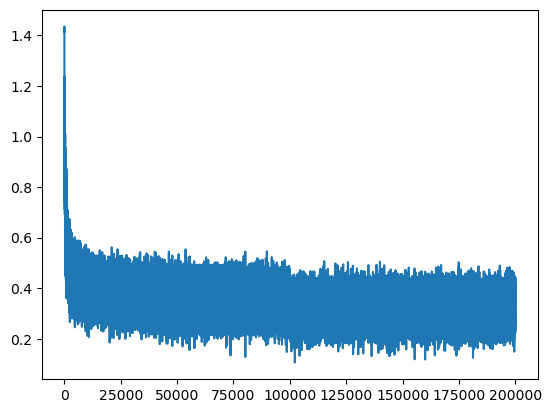

In [34]:
plt.plot(lossi) # since we're adding losses in order, don't need to plot index (it's implied), this fixes multi-run problem

In [36]:
emb = C[Xtr] # (182k, 3, 10)
print(emb.shape)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (182k, 200)
logits = h @ W2 + b2 # (182k, 27)
loss = F.cross_entropy(logits, Ytr)

# initial train resuls: tensor(2.1154, grad_fn=<NllLossBackward0>)

loss

torch.Size([182625, 3, 10])


tensor(2.1154, grad_fn=<NllLossBackward0>)

In [30]:
emb = C[Xdev] # (32, 3, 2) (numbers are wrong, copy paste error from above)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)

# initial dev results: tensor(2.1557, grad_fn=<NllLossBackward0>)

loss

tensor(2.1557, grad_fn=<NllLossBackward0>)

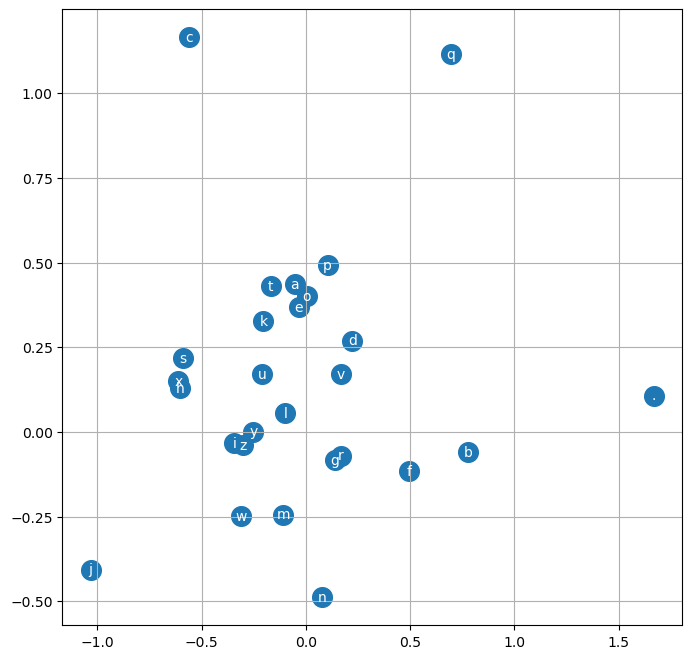

In [31]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [32]:
context = [0] * block_size
C[torch.tensor([context])].shape # three lists of the 10 input values of .

torch.Size([1, 3, 10])

In [33]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
amelle.
khi.
mili.
taty.
hacarlie.
mahnen.
delyah.
jareei.
ner.
kia.
chaiir.
kaleigh.
ham.
joce.
quinn.
sulvera.
jadai.
watelo.
dearyn.


In [ ]:
# ---- try to beat his losses ----

In [117]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

# see above
def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42) # use same seed for reproducability
random.shuffle(words) # randomize the words in case there was an ordering in the file
n1 = int(0.8*len(words)) # use 80% of the words as training
n2 = int(0.9*len(words)) # 10% as dev
                         # 10% implied as test
    
Xtr, Ytr = build_dataset(words[:n1]) # training set used to tune the weights
Xdev, Ydev = build_dataset(words[n1:n2]) # dev set used to tune hyperparams like context length, # of neurons, etc.
Xte, Yte = build_dataset(words[n2:]) # testing set used only for testing final model
                                     # any time test set is used and you act on the result, increases odds of overfitting

torch.Size([182424, 3]) torch.Size([182424])
torch.Size([22836, 3]) torch.Size([22836])
torch.Size([22886, 3]) torch.Size([22886])


In [134]:
input_dimensions = 10
num_layer1_nodes = 200
num_layer2_nodes = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, input_dimensions), generator=g) # n dimensional rep of 27 symbols
W1 = torch.randn((input_dimensions * block_size, num_layer1_nodes), generator=g) #  dimensions * block_size inputs, num_layer1_nodes first layer nodes
b1 = torch.randn(num_layer1_nodes, generator=g) # a bias for each l1 node
W3 = torch.randn(num_layer1_nodes, num_layer2_nodes, generator=g)
b3 = torch.randn(num_layer2_nodes, generator=g)
W2 = torch.randn((num_layer2_nodes, 27), generator=g) # n first layer nodes, 27 output nodes
b2 = torch.randn(27, generator=g) # a bias for each output node
parameters = [C, W1, b1, W2, b2, W3, b3] # list of all the params we can tune

In [135]:
sum(p.nelement() for p in parameters) # number of parameters in total
# inital # params: 11897

52097

In [136]:
for p in parameters: # all params need a gradient so we can tweak them
  p.requires_grad = True

In [137]:
# track the each learning rate and associated stats
# error in the video here - stepi will repeat the indicies if you run more than once
lossi = []

In [138]:
sample_size = 16

for i in range(300000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (sample_size,)) # pick sample_size random examples from the training set
  
  # forward pass
  emb = C[Xtr[ix]] # embed the selected examples
  h = torch.tanh(emb.view(-1, block_size * input_dimensions) @ W1 + b1) # activation function for each node in L1
  h2 = torch.tanh(h @ W3 + b3)
  logits = h2 @ W2 + b2 # pre-normalized values from L2
  loss = F.cross_entropy(logits, Ytr[ix]) # pytorch builtin way to so softmax
  #print(loss.item())
  
  # backward pass, don't forget to 0 the existing gradients!
  for p in parameters:
    p.grad = None
  loss.backward() # i would've thought this automatically zeroed the gradients but it does not
  
  # update each param value based on gradient calculated ^
  #lr = lrs[i]
  lr = 0.1 if i < 150000 else 0.01 # heuristically choose the step size
  for p in parameters:
    p.data += -lr * p.grad # gradient is in direction of increasing loss, so take negative step

  # track stats
  #lri.append(lre[i])
  lossi.append(loss.log10().item())

#print(loss.item())

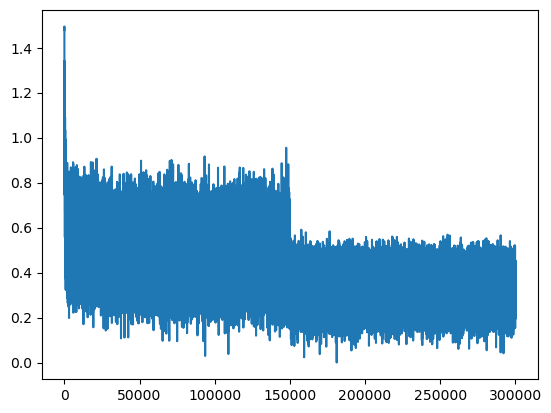

In [139]:
plt.plot(lossi) # since we're adding losses in order, don't need to plot index (it's implied), this fixes multi-run problem

In [140]:
emb = C[Xtr] # (182k, 3, 10)
print(emb.shape)
h = torch.tanh(emb.view(-1, block_size * input_dimensions) @ W1 + b1) # (182k, 200)
h2 = torch.tanh(h @ W3 + b3)
logits = h2 @ W2 + b2 # pre-normalized values from L2
loss = F.cross_entropy(logits, Ytr)

# initial train resuls: tensor(2.1154, grad_fn=<NllLossBackward0>)
# more more examples each train, fewer trains: tensor(2.2924, grad_fn=<NllLossBackward0>)
# ^ + 400 nodes instead of 200: tensor(2.2794, grad_fn=<NllLossBackward0>)
# ^ + same number of trains: tensor(2.0963, grad_fn=<NllLossBackward0>) - probably overfit
# initial settings + 4 context window: tensor(2.1590, grad_fn=<NllLossBackward0>)
# initial settings + 2 layers of 200 nodes: tensor(2.2362, grad_fn=<NllLossBackward0>) - 5x number of params 
# initial settings + 2 layers of 100 nodes: tensor(2.1274, grad_fn=<NllLossBackward0>)
# initial settings + 2 layers of 50 nodes: tensor(2.1712, grad_fn=<NllLossBackward0>)
# initial settings + 2 layers of 100 nodes + half training size + 50% more steps: tensor(2.2392, grad_fn=<NllLossBackward0>)

loss

torch.Size([182424, 3, 10])


tensor(2.2362, grad_fn=<NllLossBackward0>)

In [141]:
emb = C[Xdev] # (32, 3, 2) (numbers are wrong, copy paste error in his notebook)
h = torch.tanh(emb.view(-1, block_size * input_dimensions) @ W1 + b1) # (32, 100)
h2 = torch.tanh(h @ W3 + b3)
logits = h2 @ W2 + b2 # pre-normalized values from L2
loss = F.cross_entropy(logits, Ydev)

# initial dev results: tensor(2.1557, grad_fn=<NllLossBackward0>)
# more more examples each train, fewer trains: tensor(2.3083, grad_fn=<NllLossBackward0>)
# ^ + 400 nodes: tensor(2.3024, grad_fn=<NllLossBackward0>)
# ^ + same number of trains: tensor(2.1593, grad_fn=<NllLossBackward0>)
# initial settings + 4 context window: tensor(2.1973, grad_fn=<NllLossBackward0>)
# initial settings + 2 layers of 200 nodes: tensor(2.2776, grad_fn=<NllLossBackward0>)
# initial settings + 2 layers of 100 nodes: tensor(2.1871, grad_fn=<NllLossBackward0>)
# initial settings + 2 layers of 50 nodes: tensor(2.2207, grad_fn=<NllLossBackward0>)
# initial settings + 2 layers of 100 nodes + half training size + 50% more steps: tensor(2.2774, grad_fn=<NllLossBackward0>)

loss

tensor(2.2776, grad_fn=<NllLossBackward0>)

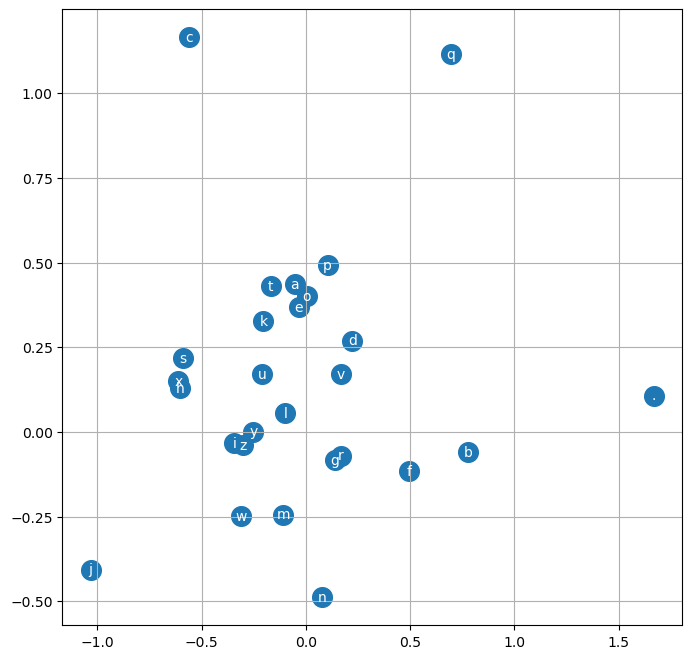

In [31]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')